In [9]:
import os
import pandas as pd
import numpy as np

temp_dir = "temp_download"

# Load autoencoder-enriched data
X_train = pd.read_csv(os.path.join(temp_dir, "X_train_enriched.csv"))
y_train = pd.read_csv(os.path.join(temp_dir, "y_train.csv"))

X_val = pd.read_csv(os.path.join(temp_dir, "X_val_enriched.csv"))
y_val = pd.read_csv(os.path.join(temp_dir, "y_val.csv"))

X_test = pd.read_csv(os.path.join(temp_dir, "X_test_enriched.csv"))

In [10]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Select top 20 features using MI
selector = SelectKBest(mutual_info_classif, k=25)
X_train_mi = selector.fit_transform(X_train, y_train.values.reshape(-1, 1))
X_val_mi = selector.transform(X_val)

# Get selected feature names
mi_mask = selector.get_support()
selected_features_mi = X_train.columns[mi_mask]

/home/nick/snap/code/181/.local/share/virtualenvs/fraud-detection-mlops-5wXwr5xg/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

# Calculate class weight ratio
fraud_ratio = sum(y_train.values) / len(y_train)  # From EDA
scale_pos_weight = ((1 - fraud_ratio) / fraud_ratio)[0]

# Initialize RFE with XGBoost
estimator = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    subsample=0.8,
    random_state=42,
    device='cuda'
)
selector = RFE(estimator, n_features_to_select=25, step=10)
selector.fit(X_train, y_train)

# Get selected features
rfe_mask = selector.support_
selected_features_rfe = X_train.columns[rfe_mask]

In [12]:
import shap

# Train XGBoost model
model = XGBClassifier(scale_pos_weight=scale_pos_weight, device='cuda').fit(X_train, y_train)

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Select top features based on mean|SHAP|
shap_importances = np.abs(shap_values).mean(axis=0)
feature_idx = np.argsort(shap_importances)[-20:]
selected_features_shap = X_train.columns[feature_idx]

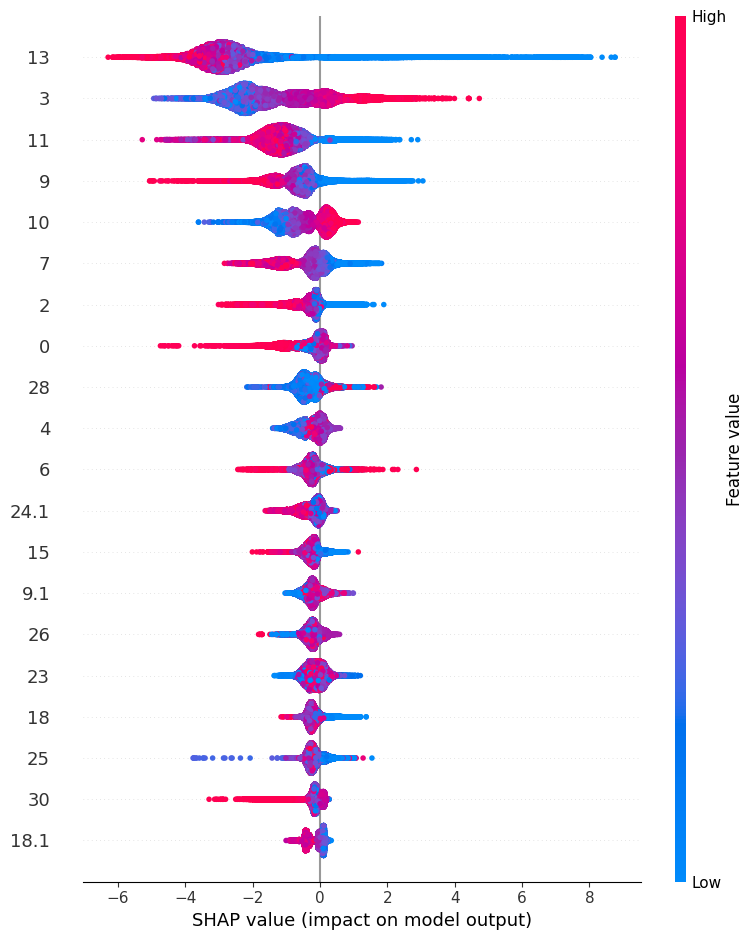

In [13]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

In [14]:
# Create voting system (features selected by ≥2 methods)
selection_matrix = pd.DataFrame({
    'MI': mi_mask,
    'RFE': rfe_mask,
    'SHAP': [col in selected_features_shap for col in X_train.columns],
})

final_selection = selection_matrix.sum(axis=1) >= 2
selected_features = X_train.columns[final_selection]

# Filter datasets
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

In [15]:
# Save selected features and datasets
selected_features.to_series().to_csv(os.path.join(temp_dir , "selected_features.csv"), index=False)
X_train_selected.to_csv(os.path.join(temp_dir, "X_train_selected.csv"), index=False)
X_val_selected.to_csv(os.path.join(temp_dir, "X_val_selected.csv"), index=False)
X_test_selected.to_csv(os.path.join(temp_dir, "X_test_selected.csv"), index=False)